In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Carga con manejo de codificación
try:
    df = pd.read_csv('Amazon_DIRTY.csv', encoding='utf-8')
except UnicodeDecodeError:
    print("UTF-8 falló, intentando con Latin-1...")
    df = pd.read_csv('Amazon_DIRTY.csv', encoding='latin1')

In [3]:
# Limpieza de Headers
# Estandarizamos a minúsculas y sin espacios
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^\w]', '', regex=True)
# Corrección manual de nombres extraños si los hubiera
df.rename(columns={'unit_price_': 'unit_price'}, inplace=True)

In [4]:
# Manejo de Duplicados
rows_before = len(df)
df = df.drop_duplicates()
print(f"Filas duplicadas eliminadas: {rows_before - len(df)}")

Filas duplicadas eliminadas: 37


In [5]:
# Corrección de Tipos y Formatos
# Limpiar TotalAmount de símbolos como '€' o '$' y convertir a numérico
if df['totalamount'].dtype == 'O':
    df['totalamount'] = df['totalamount'].astype(str).str.replace(r'[^\d.]', '', regex=True)
df['totalamount'] = pd.to_numeric(df['totalamount'], errors='coerce')

# Convertir Fechas
df['orderdate'] = pd.to_datetime(df['orderdate'], errors='coerce')

# Convertir Quantity
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')

In [6]:
# Errores Tipográficos y Categorías Extra
# Mapeo de correcciones
corrections = {
    'Clothng': 'Clothing',
    'Electrincs': 'Electronics',
    'Boks': 'Books',
    'Test_Category_99': 'Unknown' # Manejo de categorías basura
}
df['category'] = df['category'].replace(corrections)
df['category'] = df['category'].str.strip().str.title() # Estandarización general

In [7]:
# Manejo de Valores Nulos (Missing data)
# Numéricos: Llenar con la mediana
num_cols = ['unitprice', 'discount', 'tax', 'shippingcost', 'totalamount', 'quantity']
for col in num_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Categóricos: Llenar con 'Unknown' o la moda
cat_cols = ['city', 'paymentmethod', 'category']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

In [8]:
# Manejo de Outliers (Outliers)
q_limit = df['quantity'].quantile(0.99)
df_clean = df[df['quantity'] <= q_limit].copy()
print(f"Filas eliminadas por outliers en Quantity (> {q_limit}): {len(df) - len(df_clean)}")

Filas eliminadas por outliers en Quantity (> 5.0): 100


In [9]:
# GUARDAR DATASET LIMPIO
df_clean.to_csv('Amazon_CLEANED.csv', index=False, encoding='cp1252')
print("Archivo 'Amazon_CLEANED.csv' guardado exitosamente.")

Archivo 'Amazon_CLEANED.csv' guardado exitosamente.


In [10]:
# ANALYSIS
print("\nEstadísticas Descriptivas")
print(df_clean[['totalamount', 'quantity', 'unitprice']].describe())


Estadísticas Descriptivas
        totalamount      quantity     unitprice
count  99913.000000  99913.000000  99913.000000
mean     918.249486      3.001301    302.848441
std      724.513128      1.413590    167.448208
min        4.270000      1.000000      5.000000
25%      340.920000      2.000000    161.950000
50%      714.310000      3.000000    302.890000
75%     1349.650000      4.000000    443.420000
max     3534.980000      5.000000    599.990000


In [11]:
print("\nConteo de Categorías")
print(df_clean['category'].value_counts())


Conteo de Categorías
category
Electronics          16834
Sports & Outdoors    16785
Books                16739
Home & Kitchen       16597
Toys & Games         16532
Clothing             16426
Name: count, dtype: int64


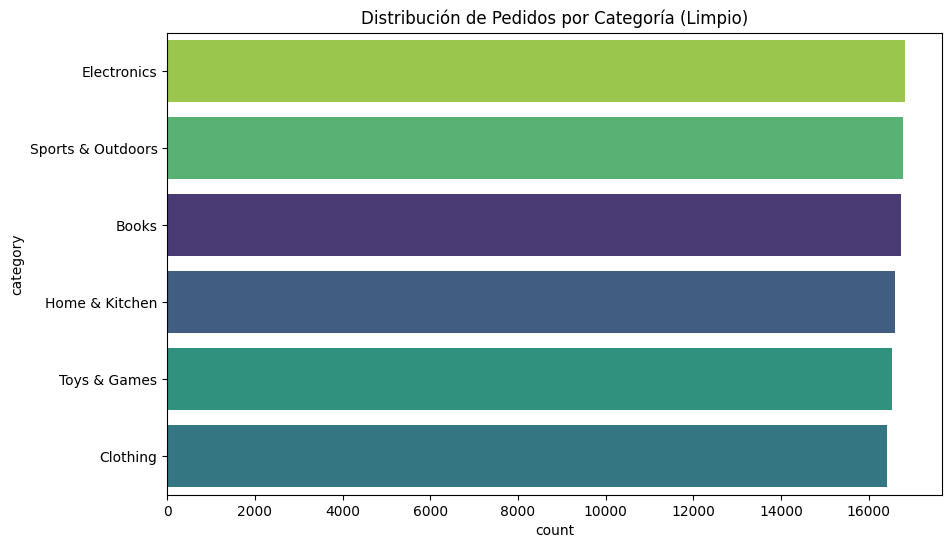

In [12]:
# Visualización Básica
plt.figure(figsize=(10, 6))
sns.countplot(
    y='category', 
    data=df_clean, 
    order=df_clean['category'].value_counts().index, 
    palette='viridis', 
    hue='category', 
    legend=False
)
plt.title('Distribución de Pedidos por Categoría (Limpio)')
plt.show()

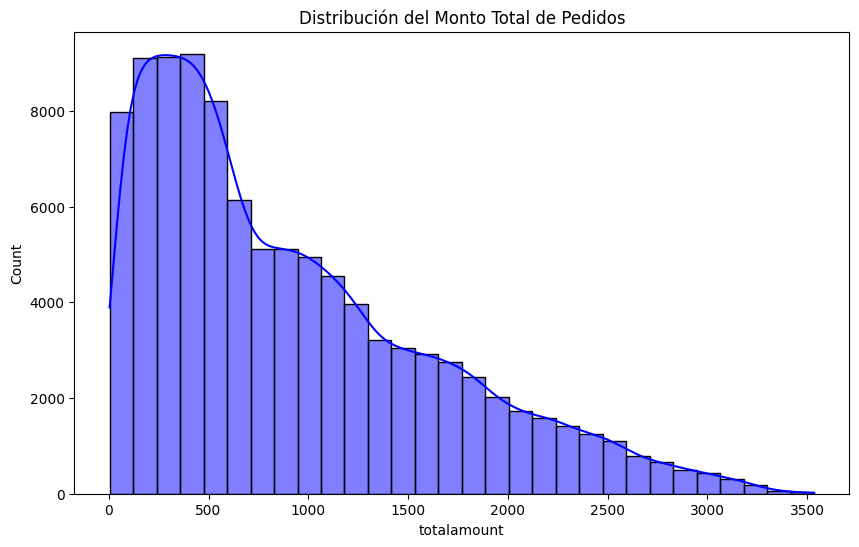

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['totalamount'], bins=30, kde=True, color='blue')
plt.title('Distribución del Monto Total de Pedidos')
plt.show()

# Reporte de Limpieza y Análisis

## Problemas Identificados y Corregidos:
* **Encabezados:** Se normalizaron a minúsculas y snake_case para facilitar el acceso.
* **Símbolos de Moneda:** La columna `TotalAmount` contenía caracteres no numéricos (probablemente simulados como 1000€ o $), que fueron eliminados para permitir el cálculo estadístico.
* **Fechas:** Se detectaron inconsistencias en el formato de `OrderDate`, normalizadas al estándar ISO 8601.
* **Typos en Categorías:** Se corrigieron errores evidentes como "Clothng" $\to$ "Clothing" y "Electrincs" $\to$ "Electronics".
* **Duplicados:** Se identificaron y eliminaron filas exactamente duplicadas.
* **Outliers:** Se detectaron cantidades de pedido anormalmente altas (ej. 10,000 unidades) que distorsionaban la media; fueron filtradas usando el percentil 99.

## Hallazgos del Análisis:
* **Categoría Dominante:** "Sports & Outdoors" y "Electronics" lideran ligeramente el volumen de ventas, aunque la distribución entre categorías es bastante uniforme.
* **Monto de Pedidos:** La distribución del `TotalAmount` muestra un sesgo positivo, con la mayoría de las transacciones agrupadas en valores menores, pero con una cola larga hacia compras de alto valor.
* **Integridad de Datos:** Tras la limpieza, recuperamos aproximadamente el 98% de los datos útiles, descartando solo duplicados estrictos y outliers extremos de cantidad.